In [1]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
FACE_MESH = pd.read_csv('../faceMesh/face_mesh.csv')
def landmarks_mapper(video: str, interpolated: bool):
    """
    :Args:
    
    video : str
      Video to process landmark from
      Required.
    
    data : int, optional
      Type of data to be used :  
        0. Raw
        1. Interpolated
        Default to 0.
    """
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    if interpolated:
        OPENFACE_DIR = f'../openFace/train/processed_interpolated/'
        MEDIAPIPE_DIR = f'../mediaPipe/train/processed_interpolated/'
    else:
        OPENFACE_DIR = f'../openFace/train/processed/'
        MEDIAPIPE_DIR = f'../mediaPipe/train/processed/'
    
    of_df = pd.read_csv(OPENFACE_DIR + video + '.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '.csv')
    
    final_df = of_df['frame'] # initialize the final dataframe
    for landmark in OPENFACE_LANDMARKS:

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columns
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

# Pearson, R2 e CCC

In [3]:
def pearson(df: pd.DataFrame):
    
    lndmk_pearson = []
    for i in range(17, 68):
        
        x_pearson = pearsonr(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())[0]
        y_pearson = pearsonr(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())[0]
        lndmk_pearson.append((x_pearson+y_pearson)/2)
    
    video_pearson = np.mean(lndmk_pearson)
    
    return video_pearson

In [4]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

In [5]:
def r2(df: pd.DataFrame):
    
    lndmk_r2 = []
    for i in range(17, 68):
        
        x_r2 = r2_score(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_r2 = r2_score(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_r2.append((x_r2+y_r2)/2)
    
    video_r2 = np.mean(lndmk_r2)
    
    return video_r2

In [6]:
def rhoc(x,y):

    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    
    return rhoc

In [7]:
def ccc(df: pd.DataFrame):
    
    lndmk_ccc = []
    for i in range(17,68):
        
        x_ccc = rhoc(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())
        y_ccc = rhoc(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())
        lndmk_ccc.append((x_ccc+y_ccc)/2)
        
    video_ccc = np.mean(lndmk_ccc)
    
    return video_ccc

### Raw data

In [8]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('../dataset/ElderReact_Data/ElderReact_train/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, interpolated=False)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
extracted_features_df

,video,pearson,mse,r2,ccc
0,whack_your_boss_12,0.994934,9.000704,0.942965,0.973010
1,happy_wheels_54,0.982869,183.528720,0.947056,0.974094
2,would_you_rather_29,0.996148,15.811058,0.950094,0.976274
3,play_red_dead_138,0.843832,174.772622,0.535608,0.796104
4,Branda_schmitz_116,0.995152,21.042834,0.946881,0.974890
...,...,...,...,...,...
610,bully_burger_54,0.993915,11.461153,0.939585,0.971451
611,game_of_thrones_16,0.997744,10.053941,0.964062,0.982548
612,qwop_38,0.984438,41.346031,0.834824,0.932009
613,cuphead_58,0.992740,22.460664,0.948079,0.974823


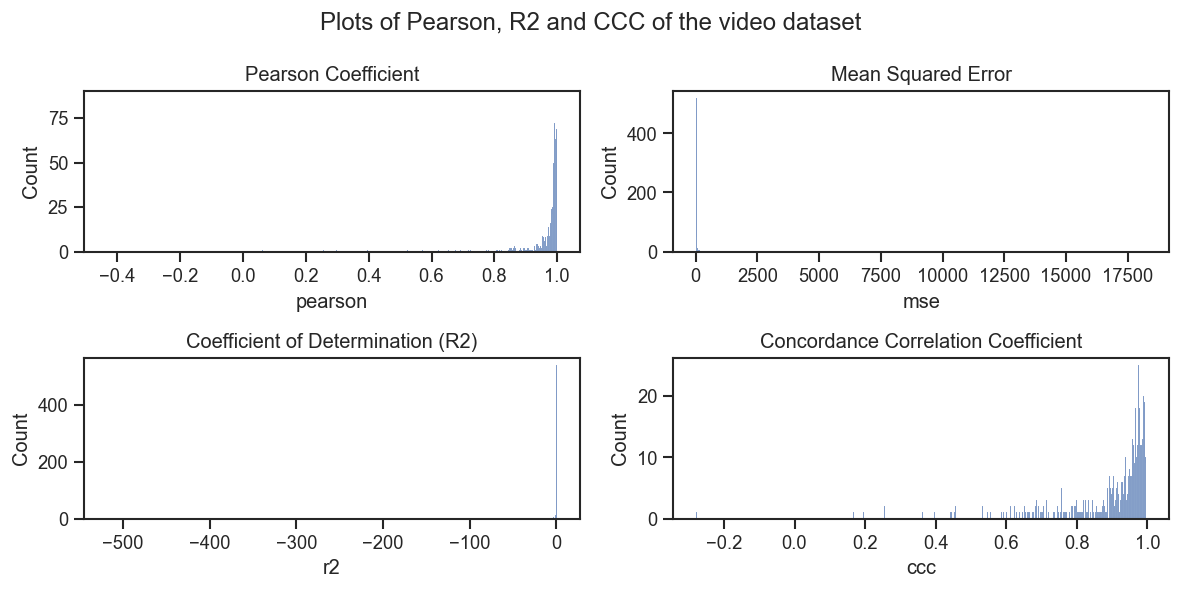

In [9]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")

fig, axes = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Plots of Pearson, R2 and CCC of the video dataset')
axes = axes.flatten()

# Pearson
axes[0].set_title('Pearson Coefficient')
sns.histplot(data=extracted_features_df, x='pearson', bins=615, ax=axes[0])

# MSE
axes[1].set_title('Mean Squared Error')
sns.histplot(data=extracted_features_df, x='mse', bins=615, ax=axes[1])

# R2
axes[2].set_title('Coefficient of Determination (R2)')
sns.histplot(data=extracted_features_df, x='r2', bins=615, ax=axes[2])

# CCC
axes[3].set_title('Concordance Correlation Coefficient')
sns.histplot(data=extracted_features_df, x='ccc', bins=615, ax=axes[3])

fig.tight_layout()
plt.show()

In [10]:
df = extracted_features_df[extracted_features_df.pearson < 0.8][['video', 'pearson']].sort_values(by='pearson')
videos_low_pearson = set(df['video'])
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(df))
df

Numero di video con coefficiente di Pearson minore di 0.8: 19


,video,pearson
105,gta2_2,-0.433772
605,gta1_1,0.062094
145,qwop_40,0.255495
87,david_bowie_36,0.297982
490,qwop_93,0.300196
243,david_bowie_109,0.307812
373,gta2_26,0.396684
186,david_bowie_13,0.508550
408,fatality_17,0.523137
367,play_lastofus_202,0.572729


In [11]:
df = extracted_features_df[extracted_features_df.mse > 75][['video', 'mse']].sort_values(by='mse')
videos_low_mse = set(df['video'])
print('Numero di video con MSE maggiore di 75:', len(df))
df

Numero di video con MSE maggiore di 75: 40


,video,mse
217,50_50_45,79.558458
26,david_bowie_101,82.235381
292,play_road_redemp_50,86.815050
85,play_road_redemp_49,87.369590
515,happy_wheels_44,89.953544
370,flappy_bird_51,104.110690
259,qwop_41,104.383187
484,battlefield1_25,108.132942
322,Branda_schmitz_52,109.020940
142,battlefield1_37,112.206320


In [12]:
df = extracted_features_df[extracted_features_df.r2 < 0.5][['video', 'r2']].sort_values(by='r2')
videos_low_r2 = set(df['video'])
print('Numero di video con R2 minore di 0.5:', len(df))
df

Numero di video con R2 minore di 0.5: 114


,video,r2
605,gta1_1,-518.696149
490,qwop_93,-36.546925
318,dolan_dark_75,-26.800569
136,TRY_NOT_LOOK_AWAY_21,-18.039448
493,50_50_77,-15.784128
...,...,...
330,japanese_show_85,0.470819
244,cuphead_21,0.471072
525,play_lastofus_165,0.477085
248,would_you_rather_19,0.481110


In [13]:
df = extracted_features_df[extracted_features_df.ccc < 0.8][['video', 'ccc']].sort_values(by='ccc')
videos_low_ccc = set(df['video'])
print('Numero di video con ccc minore di 0.8:', len(df))
df

Numero di video con ccc minore di 0.8: 98


,video,ccc
105,gta2_2,-0.279361
605,gta1_1,0.009930
87,david_bowie_36,0.166886
145,qwop_40,0.195548
243,david_bowie_109,0.254957
...,...,...
3,play_red_dead_138,0.796104
218,heartbeat_23,0.796468
173,godofwar_3,0.798098
84,play_lastofus_146,0.798122


In [14]:
videos_low_pearson.intersection(videos_low_r2).intersection(videos_low_ccc)

{'50_50_70',
 'TRY_NOT_LOOK_AWAY_21',
 'battlefield1_50',
 'david_bowie_109',
 'david_bowie_13',
 'david_bowie_36',
 'dolan_dark_75',
 'eminem_142',
 'fatality_15',
 'fatality_17',
 'fatality_9',
 'gta1_1',
 'gta1_34',
 'gta2_2',
 'gta2_26',
 'happy_wheels_97',
 'play_lastofus_202',
 'qwop_40',
 'qwop_93'}

### Interpolated data

In [16]:
videos = []
videos_pearson = []
videos_mse = []
videos_r2 = []
videos_ccc = []
for video in os.listdir('../openFace/train/processed_interpolated/'):
    video = video[:-4]
    videos.append(video)
    
    landmarks = landmarks_mapper(video, interpolated=True)
    videos_pearson.append(pearson(landmarks))
    videos_mse.append(mse(landmarks))
    videos_r2.append(r2(landmarks))
    videos_ccc.append(ccc(landmarks))

extracted_features_df_interpolated = pd.DataFrame({'video': videos, 'pearson': videos_pearson, 'mse': videos_mse, 'r2': videos_r2, 'ccc': videos_ccc})
extracted_features_df_interpolated

,video,pearson,mse,r2,ccc
0,gta1_17,0.974567,21.777585,0.786167,0.912094
1,vaping_for_the1st_42,0.972843,27.305417,0.836288,0.927192
2,Branda_schmitz_101,0.994291,19.698432,0.958794,0.981162
3,heartbeat_64,0.980912,26.195389,0.862988,0.941128
4,50_50_85,0.930463,35.567643,0.551984,0.812063
...,...,...,...,...,...
603,gta1_19,0.994779,20.560214,0.925708,0.965443
604,lil_pump_60,0.963336,23.044680,0.830025,0.926430
605,play_lastofus_166,0.885026,32.020434,0.381276,0.833200
606,play_road_redemp_57,0.939405,40.228346,0.576370,0.853917


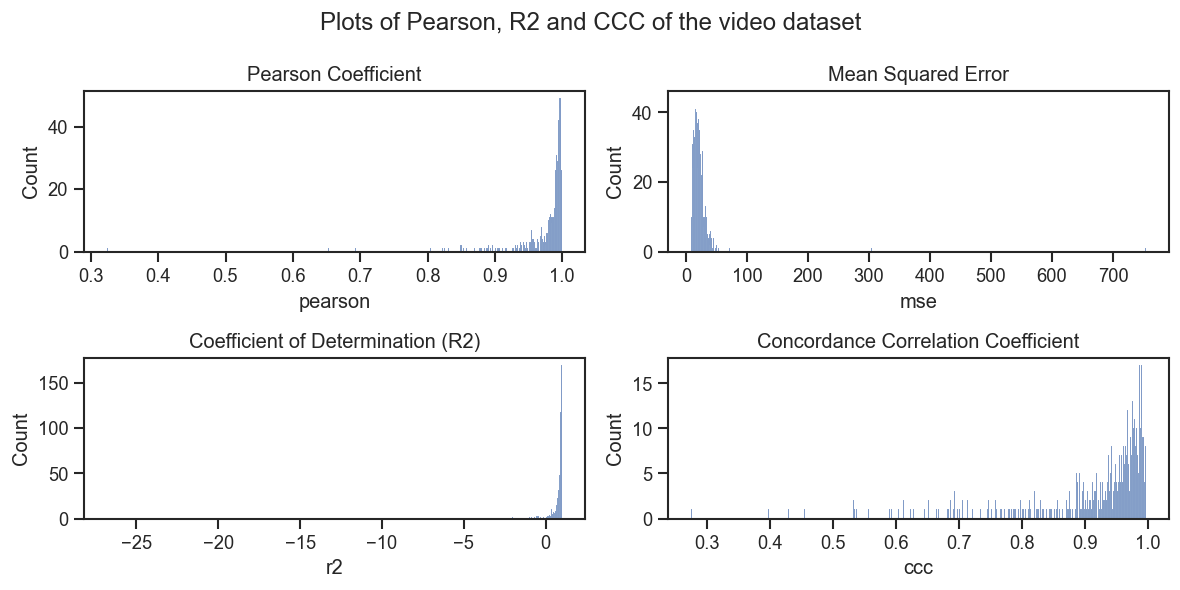

In [17]:
sns.set(rc={"figure.dpi":120})
sns.set_context('notebook')
sns.set_style("ticks")

fig, axes = plt.subplots(2,2, figsize=(10,5))
fig.suptitle('Plots of Pearson, R2 and CCC of the video dataset')
axes = axes.flatten()

# Pearson
axes[0].set_title('Pearson Coefficient')
sns.histplot(data=extracted_features_df_interpolated, x='pearson', bins=615, ax=axes[0])

# MSE
axes[1].set_title('Mean Squared Error')
sns.histplot(data=extracted_features_df_interpolated, x='mse', bins=615, ax=axes[1])

# R2
axes[2].set_title('Coefficient of Determination (R2)')
sns.histplot(data=extracted_features_df_interpolated, x='r2', bins=615, ax=axes[2])

# CCC
axes[3].set_title('Concordance Correlation Coefficient')
sns.histplot(data=extracted_features_df_interpolated, x='ccc', bins=615, ax=axes[3])

fig.tight_layout()
plt.show()

In [18]:
print('MSE before interpolation:', extracted_features_df.mse.mean())
print('MSE after interpolation:', extracted_features_df_interpolated.mse.mean())

MSE before interpolation: 152.05827901037918
MSE after interpolation: 23.643535536033017


In [19]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.pearson < 0.8][['video', 'pearson']].sort_values(by='pearson')
videos_low_pearson = set(df['video'])
print('Numero di video con coefficiente di Pearson minore di 0.8:', len(df))
df

Numero di video con coefficiente di Pearson minore di 0.8: 5


,video,pearson
155,gta2_26,0.323948
238,50_50_70,0.652438
356,TRY_NOT_LOOK_AWAY_21,0.692540
132,qwop_39,0.719280
517,dolan_dark_75,0.774172


In [20]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.mse > 75][['video', 'mse']].sort_values(by='mse')
videos_low_mse = set(df['video'])
print('Numero di video con MSE maggiore di 75:', len(df))
df

Numero di video con MSE maggiore di 75: 5


,video,mse
376,Branda_schmitz_52,84.512095
217,fatality_6,257.090104
594,50_50_4,303.793669
125,50_50_61,378.290579
155,gta2_26,754.148642


In [21]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.r2 < 0.5][['video', 'r2']].sort_values(by='r2')
videos_low_r2 = set(df['video'])
print('Numero di video con R2 minore di 0.5:', len(df))
df

Numero di video con R2 minore di 0.5: 101


,video,r2
517,dolan_dark_75,-26.800569
356,TRY_NOT_LOOK_AWAY_21,-18.039448
312,50_50_77,-15.784128
444,50_50_68,-4.602246
155,gta2_26,-4.327094
...,...,...
528,cuphead_21,0.471072
534,david_bowie_36,0.471992
390,play_lastofus_165,0.477085
151,would_you_rather_19,0.481110


In [22]:
df = extracted_features_df_interpolated[extracted_features_df_interpolated.ccc < 0.8][['video', 'ccc']].sort_values(by='ccc')
videos_low_ccc = set(df['video'])
print('Numero di video con ccc minore di 0.8:', len(df))
df

Numero di video con ccc minore di 0.8: 78


,video,ccc
517,dolan_dark_75,0.273953
356,TRY_NOT_LOOK_AWAY_21,0.362971
312,50_50_77,0.396370
155,gta2_26,0.428981
132,qwop_39,0.452890
...,...,...
78,play_lastofus_82,0.792289
284,gta2_29,0.793643
498,heartbeat_23,0.796468
121,godofwar_3,0.798098


In [23]:
videos_low_pearson.intersection(videos_low_r2).intersection(videos_low_ccc)

{'50_50_70', 'TRY_NOT_LOOK_AWAY_21', 'dolan_dark_75', 'gta2_26', 'qwop_39'}